## Introduction:
This notebook corresponds to Chapter 10. The primary objective of this notebook is to provide practical code examples that complement the explanations given in the chapter. Here, we will focus on carrying out the analysis previous to applying ARIMA and AUTO-ARIMA models.

By following the provided steps, you will gain hands-on experience in the analysis necessary to model time series with statistical tools. This practical approach aims to enhance your understanding of the concepts discussed in the chapter and strengthen your knowledge in working with time series that are highly volatile.

#### Imports
Import the necessary libraries for analyzing time series data with ARIMA. The libraries imported include pandas, numpy, matplotlib, math, statsmodels, sklearn, and pmdarima. These libraries will allow us to perform data analysis, create visualizations, and build ARIMA models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import matplotlib.pyplot as plt

!pip install pmdarima
import pmdarima as pm


#### Read the Data
Read in the data from the CSV file 'BTC-USDdaily.csv' and store it in a pandas DataFrame. The DataFrame will only contain the columns 'Date' and 'Close' that we will use.

In [2]:
cols=['Date', 'Close']
df= pd.read_csv ('./BTC-USDdaily.csv', usecols=cols)
df.head()

,Date,Close
0,9/17/2014,457.334015
1,9/18/2014,424.440002
2,9/19/2014,394.795990
3,9/20/2014,408.903992
4,9/21/2014,398.821014


#### Pre-process the Date Column
Convert the `Date` column from a string to a datetime object, specifying the format as `"%Y/%m/%d"`.

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")

Set the `Date` column as the index of the dataframe and then drop it from the dataframe, so it is not duplicated.

In [4]:
df = df.set_index(pd.DatetimeIndex(df['Date'], freq='D'))
df.drop (columns=['Date'],inplace= True )

#### Transform the Data
Transform the data by taking the natural logarithm of the dataframe. This will help to normalize the data and make it easier to work with. We have to transform the data back when making real predictions.

In [5]:
df = np.log(df)
df.head()

,Close
Date,
2014-09-17,6.125414
2014-09-18,6.050771
2014-09-19,5.978369
2014-09-20,6.013480
2014-09-21,5.988513


#### Filter the Data
We will use only the most recent data for the analysis.

In [6]:
df = df[~(df.index < '2022-01-01')]

#### Train - Test split
Split the data into two sets, a training set and a testing set. The testing set will contain the last 30 rows of the data, while the training set will contain all the previous rows.

In [7]:
limit_row= int (len (df)-30)

training_data = df[0:limit_row]['Close']
testing_data = df[limit_row:]['Close']

#### Plotting the Data
Plot the training and testing data on a graph.

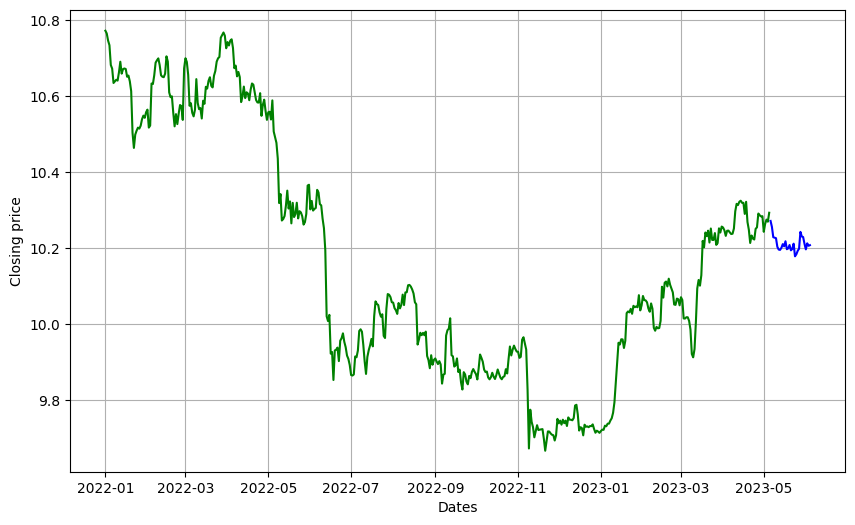

In [8]:
plt.figure (figsize=(10,6))
plt.grid (True)
plt.xlabel ('Dates')
plt.ylabel ('Closing price')
plt.plot (training_data, 'green', label= 'Train data')
plt.plot (testing_data, 'blue', label= 'Test data')

#### Autocorrelation and Partial Autocorrelation
Plot the autocorrelation and partial autocorrelation of the training data.

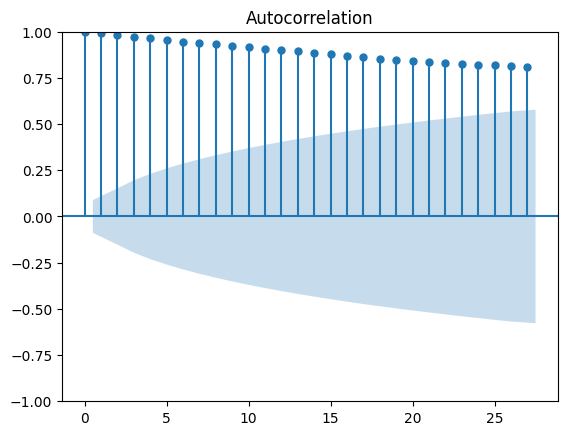

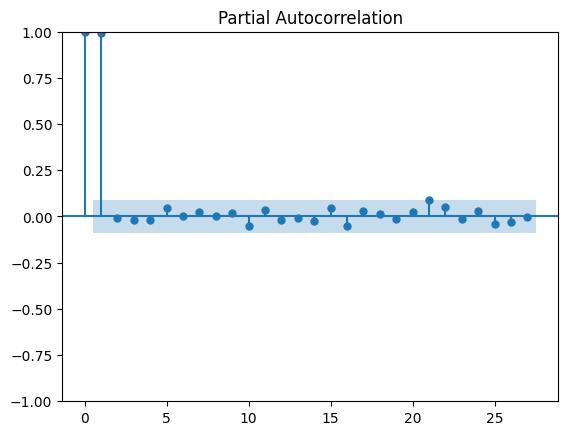

In [9]:
acf_td = plot_acf(training_data)
pacf_td = plot_pacf(training_data)

#### Calculate the Difference and plot
Calculate the difference of the training data and drop any NaN values. Plot the resulting data.

<Axes: xlabel='Date'>

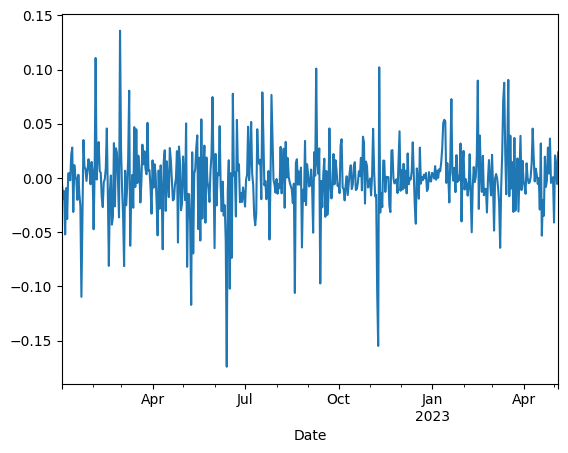

In [10]:
df_train_diff = training_data.diff().dropna()
df_train_diff.plot()

Plot the autocorrelation and partial autocorrelation of the training data differences.

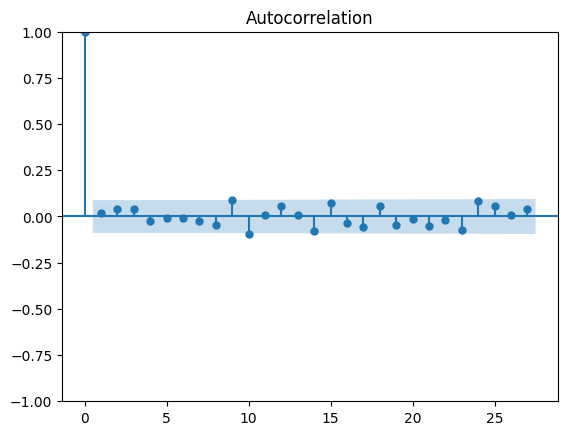

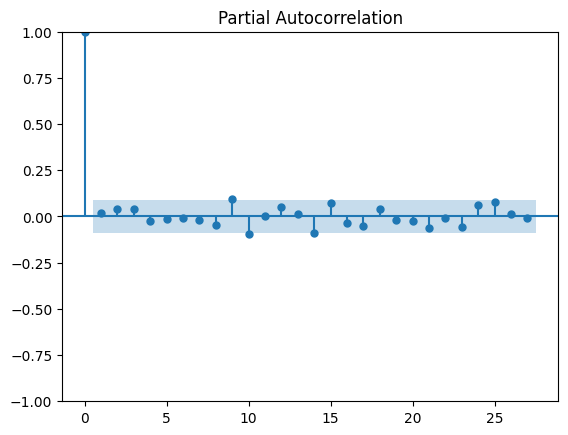

In [11]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

#### Modeling
Fit an ARIMA model to the training data with the order of (9,1,10).

In [12]:
model = ARIMA(training_data, order=(9,1,10))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  490
Model:                ARIMA(9, 1, 10)   Log Likelihood                 997.843
Date:                Sat, 23 Sep 2023   AIC                          -1955.686
Time:                        17:50:26   BIC                          -1871.839
Sample:                    01-01-2022   HQIC                         -1922.753
                         - 05-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4436      4.267     -0.104      0.917      -8.806       7.919
ar.L2          0.1553      3.593      0.043      0.966      -6.887       7.198
ar.L3          0.4897      2.411      0.203      0.8

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualize the residuals of the ARIMA model and plot their autocorrelation and partial autocorrelation.

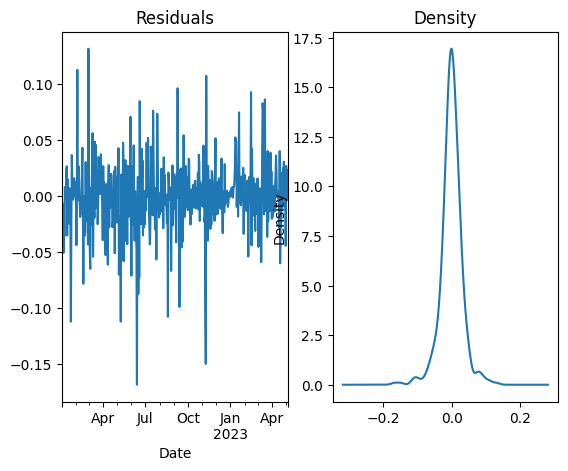

In [13]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

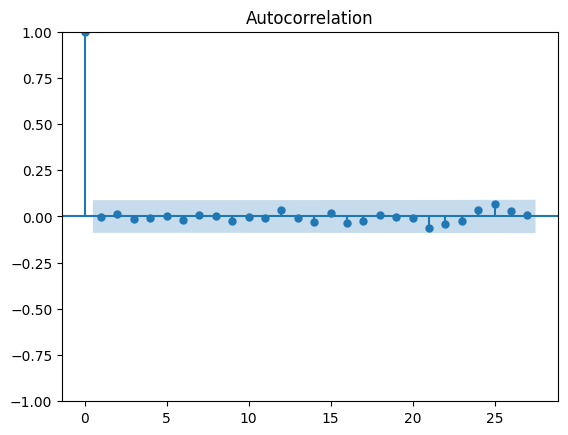

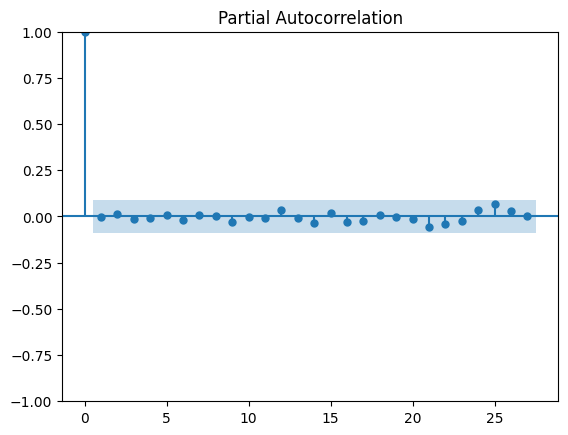

In [14]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

#### Forecast and visualize
Generate the forecast of the ARIMA model for the testing data and compare to real data.

<Axes: xlabel='Date'>

<Figure size 1000x600 with 0 Axes>

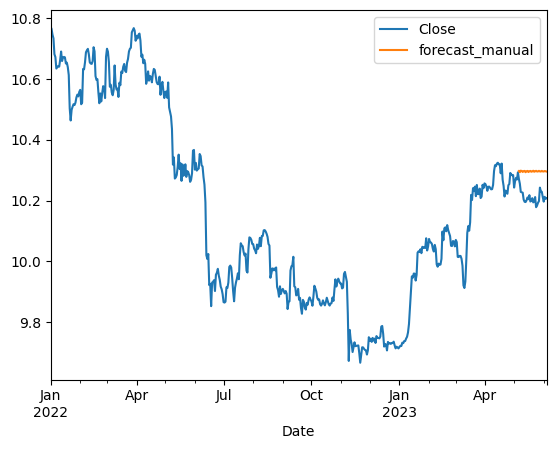

In [15]:
forecast_test = model_fit.forecast(len(testing_data))

df['forecast_manual'] = [None]*len(training_data) + list(forecast_test)
plt.figure (figsize=(10,6))
df.plot()

#### Calculate the RMSE to evaluate.
The RMSE is a measure of how well the forecast fits the data.

In [16]:
rmse_manual = np.sqrt(mean_squared_error(testing_data, forecast_test))

### Auto - Arima
Fit the auto_arima model to the training data.

In [17]:
auto_arima = pm.auto_arima(training_data, stepwise=False, seasonal=True, n_jobs=-1, trace=True)
auto_arima


Best model:  ARIMA(0,1,0)(0,0,0)[1] intercept
Total fit time: 11.392 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### Forecast and visualize
Use the auto_arima model to forecast the values of the testing data and visualize the results.

<Axes: xlabel='Date'>

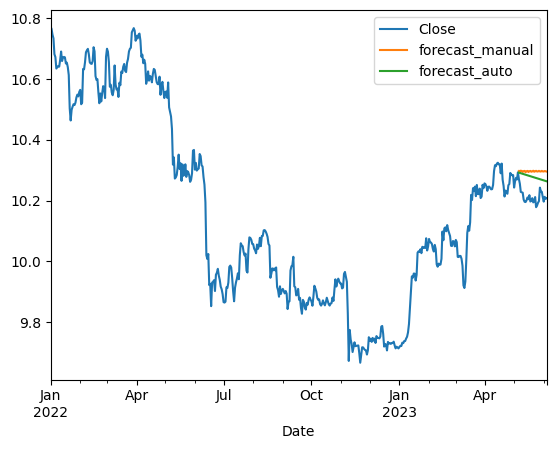

In [18]:
forecast_test_auto = auto_arima.predict(n_periods=len(testing_data))
df['forecast_auto'] = [None]*len(training_data) + list(forecast_test_auto)

df.plot()

In [19]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  490
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 987.575
Date:                Sat, 23 Sep 2023   AIC                          -1971.150
Time:                        17:50:40   BIC                          -1962.766
Sample:                    01-01-2022   HQIC                         -1967.857
                         - 05-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.001     -0.664      0.507      -0.004       0.002
sigma2         0.0010   3.68e-05     28.001      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               452.02
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Calculate the RMSE to evaluate.
The RMSE is a measure of how well the forecast fits the data.

In [20]:
rmse_auto = np.sqrt(mean_squared_error(testing_data, forecast_test_auto))

## Adding an exogenous variable

Load the data again and pre process like we did for the previous approach.  

In [21]:
cols=['Date', 'Close']
df= pd.read_csv ('./BTC-USDdaily.csv', usecols=cols)
df.head()

,Date,Close
0,9/17/2014,457.334015
1,9/18/2014,424.440002
2,9/19/2014,394.795990
3,9/20/2014,408.903992
4,9/21/2014,398.821014


In [22]:
import datetime
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y", utc=True)
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.date())

In [23]:
startdate = pd.to_datetime("2022-01-01").date()
df = df[~(df['Date'] < startdate)]

In [24]:
df.head()

,Date,Close
2663,2022-01-01,47686.81250
2664,2022-01-02,47345.21875
2665,2022-01-03,46458.11719
2666,2022-01-04,45897.57422
2667,2022-01-05,43569.00391


In [25]:
df = df.set_index(pd.DatetimeIndex(df['Date'], freq='D'))
df.drop (columns=['Date'],inplace= True )

In [26]:
df = np.log(df)
df.head()

,Close
Date,
2022-01-01,10.772410
2022-01-02,10.765221
2022-01-03,10.746306
2022-01-04,10.734168
2022-01-05,10.682101


### Load the news dataset

In [27]:
new_df= pd.read_csv ('/content/joint_news_df.csv')

#### Mapping Sentiment
Map the sentiment column to a numerical value and create a new column called `sentiment_number`.

In [28]:
sentiment_mapping = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': -1
}
new_df['sentiment_number'] = new_df['sentiment'].map(sentiment_mapping)

#### Grouping and Filtering Data
Group the `sentiment_number` column by day and sum the values, then reset the index.

In [29]:
day_sentiment_df= new_df.groupby(new_df['day'])['sentiment_number'].sum().reset_index()
day_sentiment_df = day_sentiment_df[day_sentiment_df.day != '2023-06-06'] #drop as this date is not present in the main df
day_sentiment_df = day_sentiment_df[day_sentiment_df.day != '2023-06-05'] #drop as this date is not present in the main df
day_sentiment_df.shape

(520, 2)

In [30]:
day_sentiment_df.head()

,day,sentiment_number
0,2022-01-01,-9
1,2022-01-02,5
2,2022-01-03,4
3,2022-01-04,-11
4,2022-01-05,-5


#### Calculate Z-Scores
Calculate the z-scores for each value in the `sentiment_number` column of the day_sentiment_df dataframe and set a threshold against which we will consider a value to be outlier.

In [31]:
z_scores = np.abs((day_sentiment_df["sentiment_number"] - day_sentiment_df["sentiment_number"].mean()) / day_sentiment_df["sentiment_number"].std())
threshold = 3

#### Identifying Outliers and reinforce their effect.
Identify any values in the sentiment_number column of the day_sentiment_df dataframe that have a z-score greater than the threshold of 3 and multiply them by a factor of 2. Replace the original dataframe with the multiplied outliers.

In [32]:
outliers = day_sentiment_df[z_scores > threshold]
outliers['sentiment_number'] = outliers['sentiment_number'] * 2
day_sentiment_df.update(outliers)
day_sentiment_df.head()

<ipython-input-32-c85de259bcd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['sentiment_number'] = outliers['sentiment_number'] * 2


,day,sentiment_number
0,2022-01-01,-9.0
1,2022-01-02,5.0
2,2022-01-03,4.0
3,2022-01-04,-11.0
4,2022-01-05,-5.0


Set the `Day` column as the index of the dataframe and then drop it from the dataframe, so it is not duplicated.

In [33]:
day_sentiment_df = day_sentiment_df.set_index(pd.DatetimeIndex(day_sentiment_df['day'], freq='D'))
day_sentiment_df.drop (columns=['day'],inplace= True )

#### Train Test split

Split the data into training and testing sets, with the testing set containing the last 30 rows of the dataframe and the training set containing all the previous rows. Execute this for both datasets.

In [34]:
training_data = df[0:limit_row]['Close']
testing_data = df[limit_row:]['Close']
training_data_exog = day_sentiment_df[0:limit_row]['sentiment_number']
testing_data_exog = day_sentiment_df[limit_row:]['sentiment_number']

Transform exogenous data into a numpy array

In [35]:
exogenous_data_training=training_data_exog.to_numpy()
exogenous_data_test=testing_data_exog.to_numpy()

#### Fit the SARIMAX Model
Fit the SARIMAX model to the training_data and exogenous_data_training variables, using the same order of the previous try.

In [36]:
model = SARIMAX(training_data, exog=exogenous_data_training, order=(9,1,10))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  490
Model:              SARIMAX(9, 1, 10)   Log Likelihood                1019.247
Date:                Sat, 23 Sep 2023   AIC                          -1996.494
Time:                        17:50:48   BIC                          -1908.455
Sample:                    01-01-2022   HQIC                         -1961.915
                         - 05-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004   3.53e-05     10.544      0.000       0.000       0.000
ar.L1         -0.3407      4.506     -0.076      0.940      -9.173       8.491
ar.L2          0.1055      0.837      0.126      0.9

Visualize the residuals of the SARIMAX model and plot their autocorrelation and partial autocorrelation.

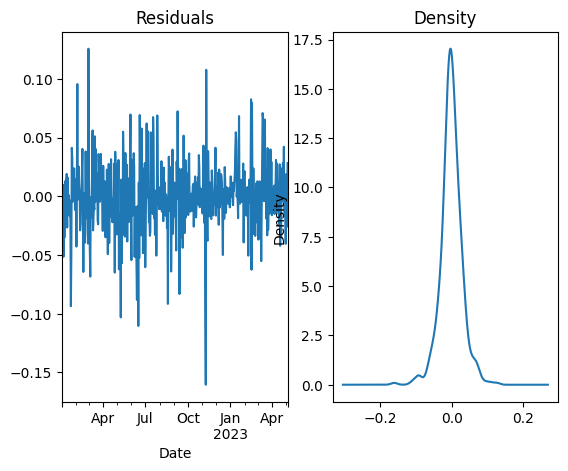

In [37]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

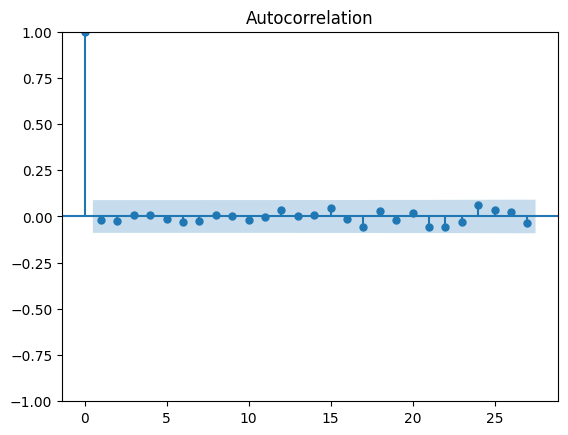

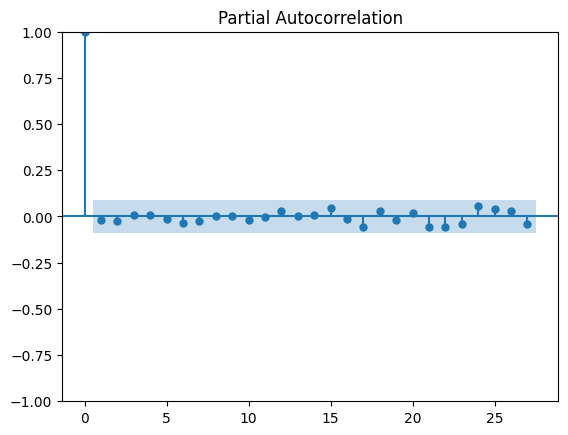

In [38]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

#### Forecast and visualize
Generate the forecast of the SARIMAX model for the testing data and compare to real data.

<Axes: xlabel='Date'>

<Figure size 1000x600 with 0 Axes>

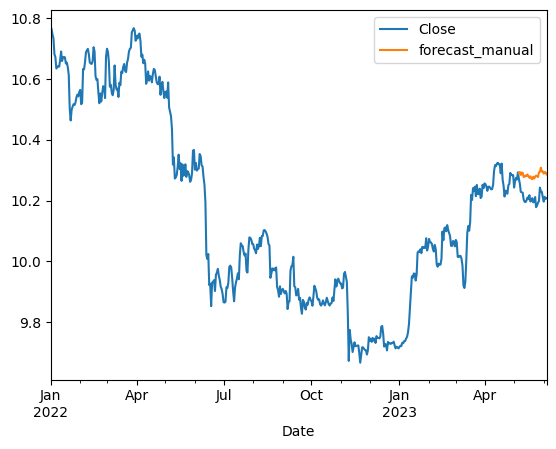

In [39]:
forecast_test = model_fit.forecast(len(testing_data), exog=exogenous_data_test)

df['forecast_manual'] = [None]*len(training_data) + list(forecast_test)
plt.figure (figsize=(10,6))
df.plot()

#### Calculate the RMSE to evaluate.
The RMSE is a measure of how well the forecast fits the data.

In [40]:
rmse_exog = np.sqrt(mean_squared_error(testing_data, forecast_test))

#### Reshape the Exogenous Data
Reshape the exogenous data from the training and testing sets into the correct shape for use in the auto arima model.

In [41]:
exog_reshaped=exogenous_data_training.reshape (-1,1)
exogenous_data_test_shaped=exogenous_data_test.reshape (-1,1)

#### Fit an Auto ARIMA Model
Fit an Auto ARIMA model to the training data, using the exogenous data.

In [42]:
auto_arima = pm.auto_arima(training_data, X=exog_reshaped, stepwise=False, seasonal=True, n_jobs=-1)
auto_arima

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

#### Forecast and visualize
Generate the forecast of the AUTO ARIMA model for the testing data and compare to real data.

<Axes: xlabel='Date'>

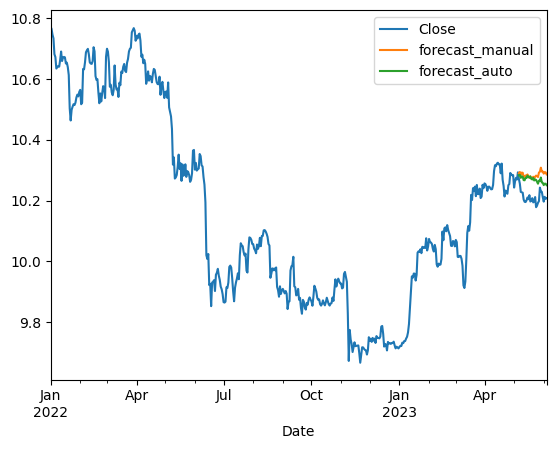

In [43]:
forecast_test_auto = auto_arima.predict(n_periods=len(testing_data), X=exogenous_data_test_shaped)
df['forecast_auto'] = [None]*len(training_data) + list(forecast_test_auto)

df.plot()

In [44]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  490
Model:               SARIMAX(0, 1, 2)   Log Likelihood                1014.350
Date:                Sat, 23 Sep 2023   AIC                          -2018.701
Time:                        17:50:59   BIC                          -1997.739
Sample:                    01-01-2022   HQIC                         -2010.467
                         - 05-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0012      0.002     -0.788      0.431      -0.004       0.002
x1             0.0004   3.18e-05     12.143      0.000       0.000       0.000
ma.L1         -0.0582      0.034     -1.707      0.088      -0.125       0.009
ma.L2          0.1194      0.046      2.623      0.009       0.030       0.209
sigma2         0.0009   3.82e-05     24.379      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               227.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Calculate RMSE and compare
Calculate the RMSE for the Auto ARIMA model and compare with all the the other models trained in this notebook.

In [45]:
rmse_exog_auto = np.sqrt(mean_squared_error(testing_data, forecast_test_auto))
print(f'rmse - manual_search: {rmse_manual}')
print(f'rmse - manual+exog: {rmse_exog}')
print ('-----------------------------------------')
print(f'rmse - autoarima: {rmse_auto}')
print(f'rmse - autoarima+exog: {rmse_exog_auto}')

rmse - manual_search: 0.08758619957849932
rmse - manual+exog: 0.07601096749570253
-----------------------------------------
rmse - autoarima: 0.06934518111478132
rmse - autoarima+exog: 0.06091899467123534


To compare with the LSTM results that we analyze in the subsequent section we transform back from log number to the original unit of the dataset (USD)

In [46]:
testing_data= np.exp(testing_data)
forecast_test_auto=np.exp(forecast_test_auto)
rmse_exog_auto = np.sqrt(mean_squared_error(testing_data, forecast_test_auto))
rmse_exog_auto

1700.0369592191532